**Analisi del grafo**

Analisi delle caratteristiche e della vulnerabilità della Rete di Trasporto Pubblica Metropolitana Milanese  
*Progetto del corso di Data Analytics*


Andrea Broccoletti  
*Matricola 886155*

In [119]:
import igraph as ig
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [120]:
graph_file = "../assets/static/graphs/atm_network.pkl"

In [121]:
G = ig.Graph.Read_Pickle(graph_file)

# Nodi e archi

In [122]:
print("Numero di vertici:", G.vcount())

Numero di vertici: 125


In [123]:
print("Numero di archi:", G.ecount())

Numero di archi: 129


## Numero di vertici per ogni linea

In [124]:
line_vertex_counts = {}

for v in G.vs:
    for line in v['lines']:
        if line not in line_vertex_counts:
            line_vertex_counts[line] = 0
        line_vertex_counts[line] += 1
        
print("\nNumero di vertici per ogni linea:")
for line, count in line_vertex_counts.items():
    print(f"Linea {line}: {count} vertici")


Numero di vertici per ogni linea:
Linea 2: 35 vertici
Linea 5: 19 vertici
Linea 1: 38 vertici
Linea 3: 21 vertici
Linea 4: 21 vertici


## Numero di archi per ogni linea

In [125]:

edge_line_counts = {}

for e in G.es:
    for line in e['lines']:
        if line not in edge_line_counts:
            edge_line_counts[line] = 0
        edge_line_counts[line] += 1
        
print("\nNumero di archi per ogni linea:")
for line, count in edge_line_counts.items():
    print(f"Linea {line}: {count} archi")


Numero di archi per ogni linea:
Linea 2: 34 archi
Linea 5: 18 archi
Linea 1: 37 archi
Linea 3: 20 archi
Linea 4: 20 archi


# Gradi

In [126]:
degrees = G.degree()

In [127]:
degree_counts = pd.Series(degrees).value_counts().sort_index()
print("\nDistribuzione dei gradi dei vertici:")
print(degree_counts)


Distribuzione dei gradi dei vertici:
1     13
2    100
3      3
4      9
Name: count, dtype: int64


In [128]:
degree_prob = degree_counts / degree_counts.sum()

print("\nDistribuzione di probabilità dei gradi dei vertici:")
print(degree_prob)


Distribuzione di probabilità dei gradi dei vertici:
1    0.104
2    0.800
3    0.024
4    0.072
Name: count, dtype: float64


In [129]:
min_degree = np.min(degrees)
max_degree = np.max(degrees)
avg_degree = np.mean(degrees)
std_degree = np.std(degrees)

print("\nStatistiche della distribuzione dei gradi:")
print("Grado minimo:", min_degree)
print("Grado massimo:", max_degree)
print("Grado medio:", avg_degree)
print("Deviazione standard del grado:", std_degree)


Statistiche della distribuzione dei gradi:
Grado minimo: 1
Grado massimo: 4
Grado medio: 2.064
Deviazione standard del grado: 0.6417974758442104


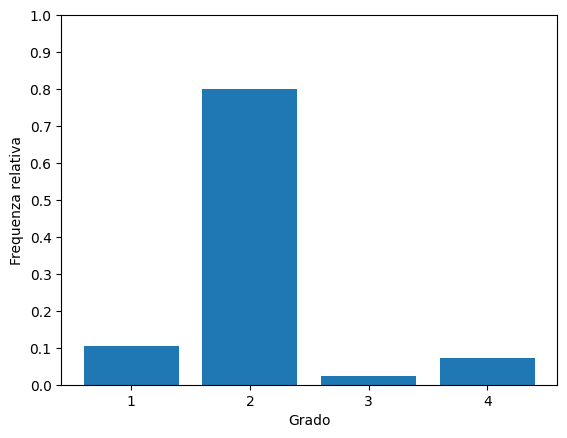

In [130]:
plt.bar(degree_prob.index, degree_prob.values, width=0.8)
plt.xlabel('Grado')
plt.ylabel('Frequenza relativa')
plt.xticks(range(min_degree, max_degree + 1, 1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.show()

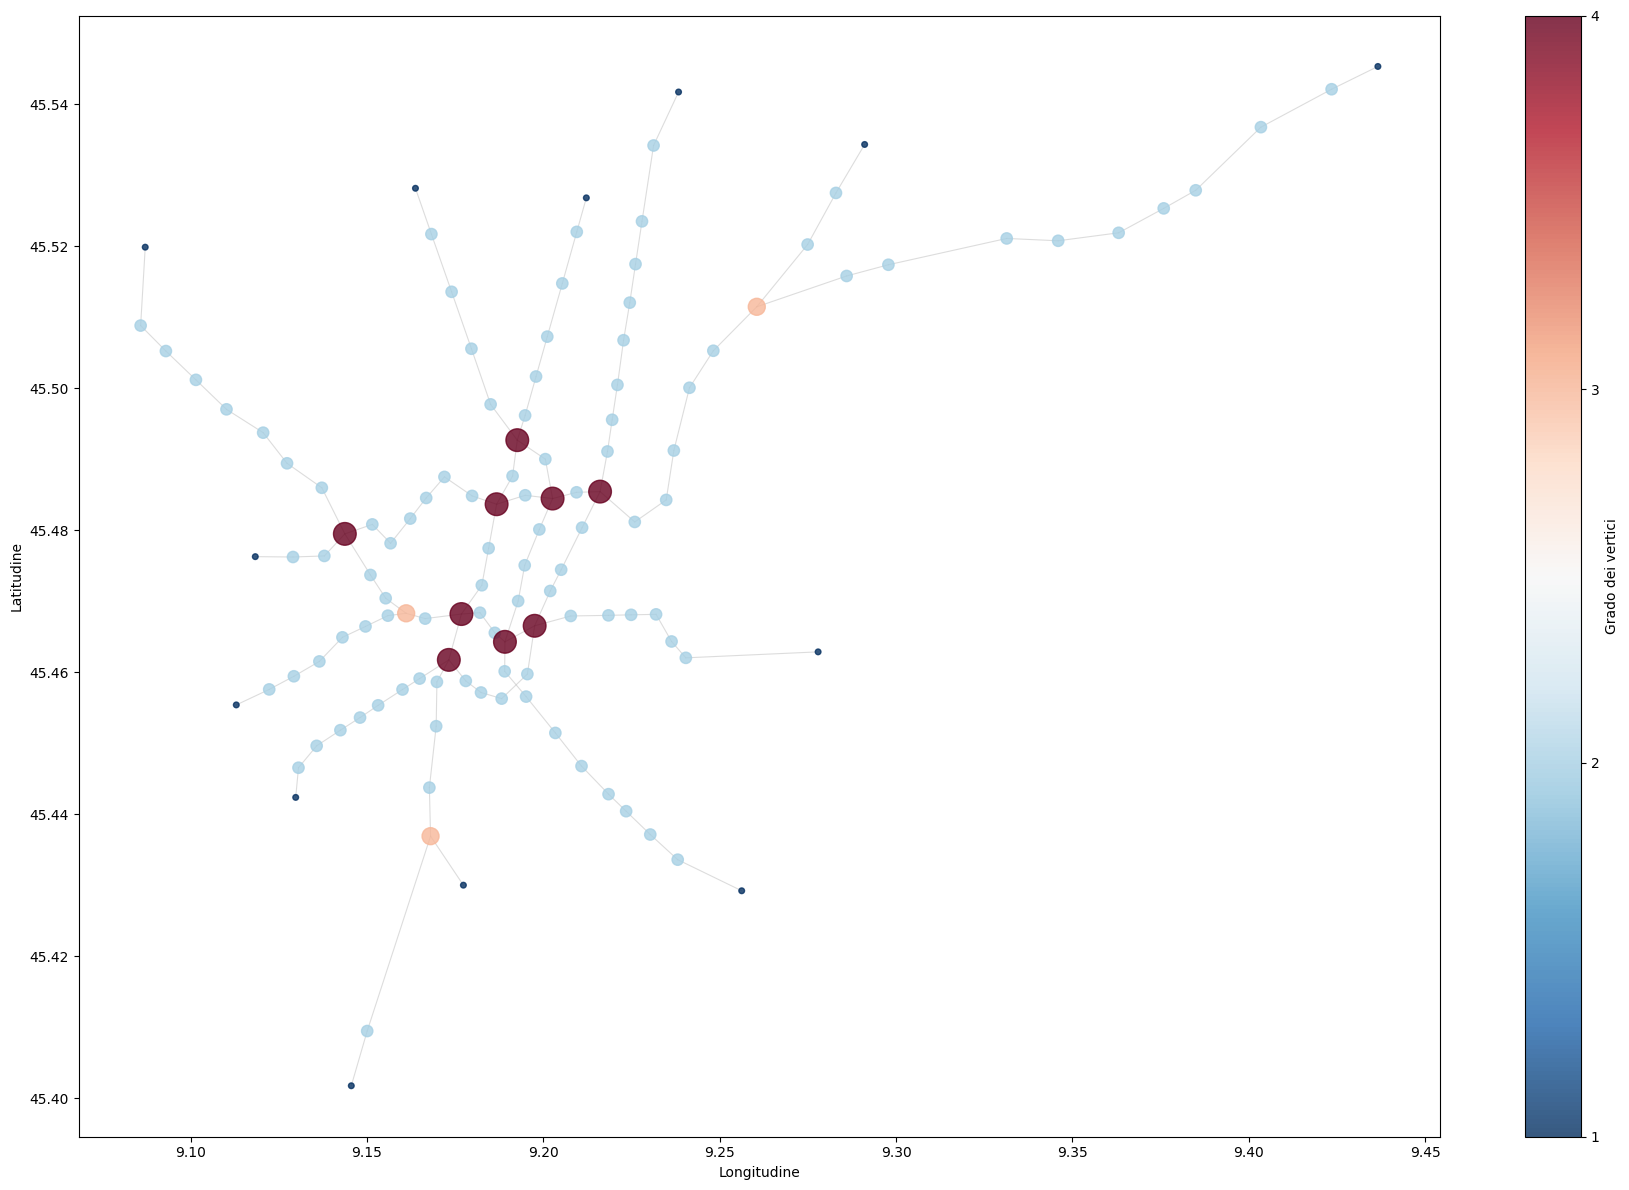

In [131]:
latitudes = G.vs['latitude']
longitudes = G.vs['longitude']
x_coords = list(longitudes)
y_coords = list(latitudes)

plt.figure(figsize=(18, 12))


edge_color = "#bbbbbb"
for e in G.es:
    v1, v2 = e.tuple
    x = [x_coords[v1], x_coords[v2]]
    y = [y_coords[v1], y_coords[v2]]
    plt.plot(x, y, color=edge_color, linewidth=0.8, alpha=0.5, zorder=1)

# I nodi sono proporzionali in dimensine al loro grado
deg_arr = np.array(degrees)
idx_sorted = np.argsort(deg_arr)  # crescente
x_sorted = [x_coords[i] for i in idx_sorted]
y_sorted = [y_coords[i] for i in idx_sorted]
deg_sorted = deg_arr[idx_sorted]

# La propozione è data sul quadrato per far risaltare i nodi con grado maggiore
dims_sorted = [((deg - min_degree + 1) / (max_degree - min_degree)) ** 2 * 150 for deg in deg_sorted]

# disegna nodi sopra gli archi, nell'ordine ordinato per far emergere i gradi maggiori
scatter = plt.scatter(x_sorted, y_sorted, s=dims_sorted, c=deg_sorted, cmap='RdBu_r', alpha=0.8, zorder=2)
plt.colorbar(scatter, label='Grado dei vertici', ticks=range(min_degree, max_degree + 1, 1))
plt.xlabel('Longitudine')
plt.ylabel('Latitudine')
plt.tight_layout()
plt.show()

# Cammini

## Diametro

In [132]:
diameter = G.diameter()
print("\nDiametro del grafo:", diameter)


Diametro del grafo: 35


## Mean Path Length

In [133]:
mean_path_length = G.average_path_length()
print("Lunghezza media dei cammini", mean_path_length)

Lunghezza media dei cammini 12.101161290322581


## Distribuzione delle distanze tra i nodi

/var/folders/7y/3hmq48t14mb2btvcr85krp780000gn/T/ipykernel_80033/2472367801.py:1: DeprecationWarning: Graph.shortest_paths() is deprecated; use Graph.distances() instead
  dist_matrix = np.array(G.shortest_paths())


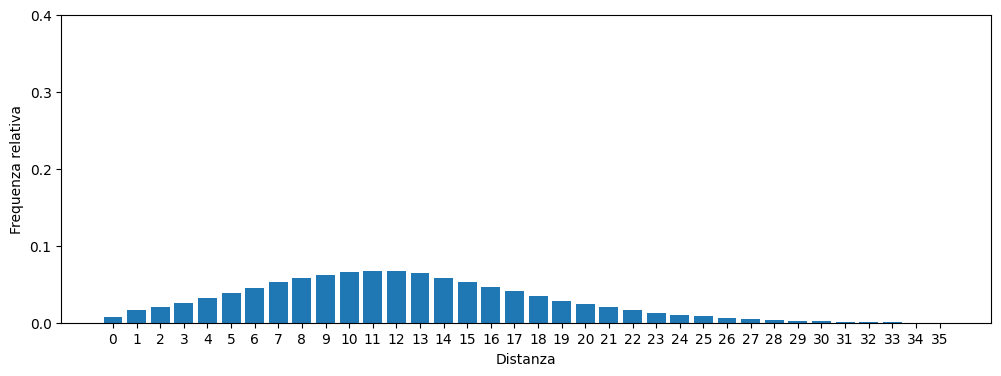

In [134]:
dist_matrix = np.array(G.shortest_paths())
distances = dist_matrix.flatten()
dist_counts = pd.Series(distances).value_counts().sort_index()
dist_prob = dist_counts / dist_counts.sum()

plt.figure(figsize=(12, 4))
plt.bar(dist_prob.index, dist_prob.values, width=0.8)
plt.xlabel('Distanza')
plt.ylabel('Frequenza relativa')
plt.xticks(range(int(dist_prob.index.min()), int(dist_prob.index.max()) + 1, 1))
plt.yticks(np.arange(0, 0.5, 0.1))
plt.show()

## efficienza globale

In [135]:
# Calcola tutte le distanze minime tra coppie di nodi
distances = np.array(G.shortest_paths())

# Calcola l'inverso delle distanze (1/d)
with np.errstate(divide='ignore'):
    inv_dist = 1 / distances

# Imposta 1/0 e 1/inf a 0 (distanze nulle o non raggiungibili)
inv_dist[~np.isfinite(inv_dist)] = 0

# Calcola efficienza globale
n = G.vcount()
E_global = inv_dist.sum() / (n * (n - 1))

print(f"Efficienza globale: {E_global:.4f}")

Efficienza globale: 0.1262


/var/folders/7y/3hmq48t14mb2btvcr85krp780000gn/T/ipykernel_80033/1308050139.py:2: DeprecationWarning: Graph.shortest_paths() is deprecated; use Graph.distances() instead
  distances = np.array(G.shortest_paths())


## Raggio

In [136]:
# raggio del grafo
radius = G.radius()
print("Raggio del grafo:", radius)

Raggio del grafo: 18


# Clustering

In [137]:
clustering_coeffs = G.transitivity_local_undirected(vertices=None, mode="zero")
avg_clustering_coeff = np.mean(clustering_coeffs)
global_clustering_coeff = G.transitivity_undirected()

print("\nCoefficienti di clustering:")
print("Coefficiente di clustering medio:", avg_clustering_coeff)
print("Coefficiente di clustering globale:", global_clustering_coeff)


Coefficienti di clustering:
Coefficiente di clustering medio: 0.0
Coefficiente di clustering globale: 0.0


# Componenti

In [138]:
components = G.components()
largest_component = components.giant()
relative_size_largest_component = largest_component.vcount() / G.vcount()


In [139]:
print("Numero di componenti connesse:", len(components))
print("Dimensione relativa del più grande sottografo connesso:", relative_size_largest_component)
print("Giant component vcount:", largest_component.vcount())

Numero di componenti connesse: 1
Dimensione relativa del più grande sottografo connesso: 1.0
Giant component vcount: 125


# Centralità

In [140]:
# Centralità in termini di degree, betweenness, closeness, eigenvector
degree_centrality = G.degree()
betweenness_centrality = G.betweenness()
closeness_centrality = G.closeness()
eigenvector_centrality = G.eigenvector_centrality()

In [141]:
print("Centralità di grado:", np.mean(degree_centrality))
print("Centralità di intermediazione:", np.mean(betweenness_centrality))
print("Centralità di prossimità:", np.mean(closeness_centrality))
print("Centralità di autovettore:", np.mean(eigenvector_centrality))

Centralità di grado: 2.064
Centralità di intermediazione: 688.272
Centralità di prossimità: 0.08779639628700454
Centralità di autovettore: 0.18612399117632852


## Top 10 Stazioni per misura di centralità

In [142]:
top_n = 10

top_degree = np.argsort(degree_centrality)[-top_n:][::-1]
top_betweenness = np.argsort(betweenness_centrality)[-top_n:][::-1]
top_closeness = np.argsort(closeness_centrality)[-top_n:][::-1]
top_eigenvector = np.argsort(eigenvector_centrality)[-top_n:][::-1]
top_pagerank = np.argsort(pagerank_centrality)[-top_n:][::-1]

print("\nTop", top_n, "vertici per centralità di grado:")
for idx in top_degree:
    print(G.vs[idx]['stop_name'])

print("\nTop", top_n, "vertici per centralità di intermediazione:")
for idx in top_betweenness:
    print(G.vs[idx]['stop_name'])

print("\nTop", top_n, "vertici per centralità di prossimità:")
for idx in top_closeness:
    print(G.vs[idx]['stop_name'])

print("\nTop", top_n, "vertici per centralità di autovettore:")
for idx in top_eigenvector:
    print(G.vs[idx]['stop_name'])

print("\nTop", top_n, "vertici per centralità PageRank:")
for idx in top_pagerank:
    print(G.vs[idx]['stop_name'])


Top 10 vertici per centralità di grado:
SAN AMBROGIO
GARIBALDI FS
SAN BABILA
ZARA
CENTRALE FS
LOTTO
DUOMO
CADORNA
LORETO
FAMAGOSTA

Top 10 vertici per centralità di intermediazione:
CADORNA
LORETO
GARIBALDI FS
CENTRALE FS
CAIAZZO
PIOLA
DUOMO
SAN AMBROGIO
LAMBRATE FS
UDINE

Top 10 vertici per centralità di prossimità:
CADORNA
CENTRALE FS
LANZA
GARIBALDI FS
MOSCOVA
DUOMO
GIOIA
CAIROLI
CORDUSIO
CAIAZZO

Top 10 vertici per centralità di autovettore:
CENTRALE FS
GARIBALDI FS
CADORNA
ZARA
DUOMO
SAN AMBROGIO
SAN BABILA
GIOIA
SONDRIO
ISOLA

Top 10 vertici per centralità PageRank:
LOTTO
LORETO
ZARA
SAN AMBROGIO
SAN BABILA
DUOMO
GARIBALDI FS
CADORNA
CENTRALE FS
FAMAGOSTA


## Ultimi 10 nodi per closeness

In [143]:
bottom_n = 10
bottom_closeness = np.argsort(closeness_centrality)[:bottom_n]

print("\nBottom", bottom_n, "vertici per centralità di prossimità:")
for idx in bottom_closeness:
    print(G.vs[idx]['stop_name'])


Bottom 10 vertici per centralità di prossimità:
GESSATE
CASCINA ANTONIETTA
GORGONZOLA
VILLA POMPEA
BUSSERO
RHO FIERAMILANO
CASSINA DE PECCHI
PERO
SESTO 1 MAGGIO FS
VILLA FIORITA


## Rappresentazioni grafiche delle 
I coefficienti di ingrandimento/diminuzione della grandezza dei nodi sono stati trovati a tentativi,  
cercando i valori che risultassero visivamente più effiaci.

In [144]:
latitudes = G.vs['latitude']
longitudes = G.vs['longitude']

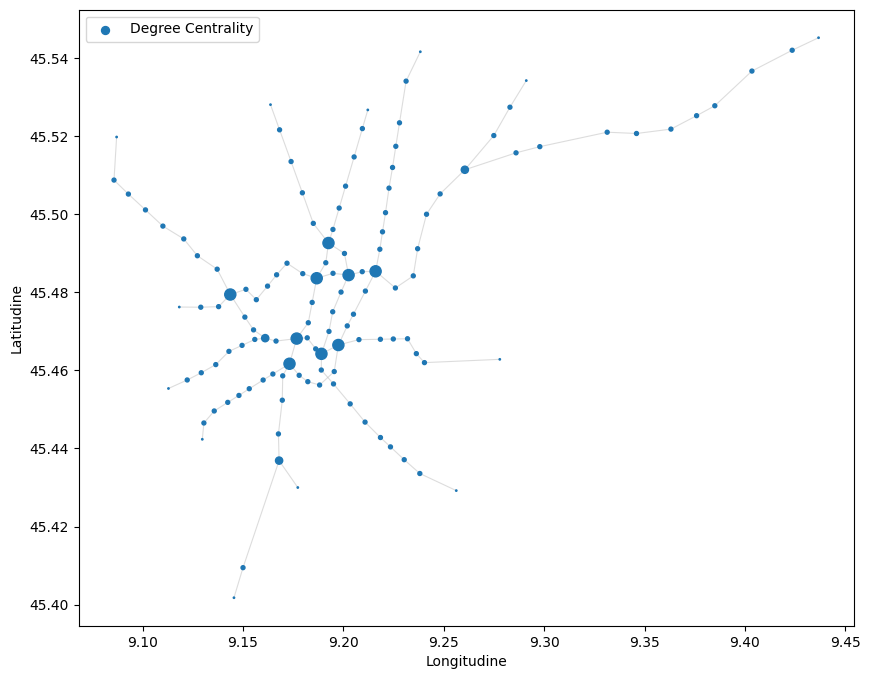

In [145]:
plt.figure(figsize=(10, 8))

edge_color = "#bbbbbb"
for e in G.es:
    v1, v2 = e.tuple
    x = [longitudes[v1], longitudes[v2]]
    y = [latitudes[v1], latitudes[v2]]
    plt.plot(x, y, color=edge_color, linewidth=0.8, alpha=0.5, zorder=1)

plt.scatter(longitudes, latitudes, s=np.array(degree_centrality)**3, alpha=1, label='Degree Centrality')
plt.xlabel('Longitudine')
plt.ylabel('Latitudine')
plt.legend()
plt.show()

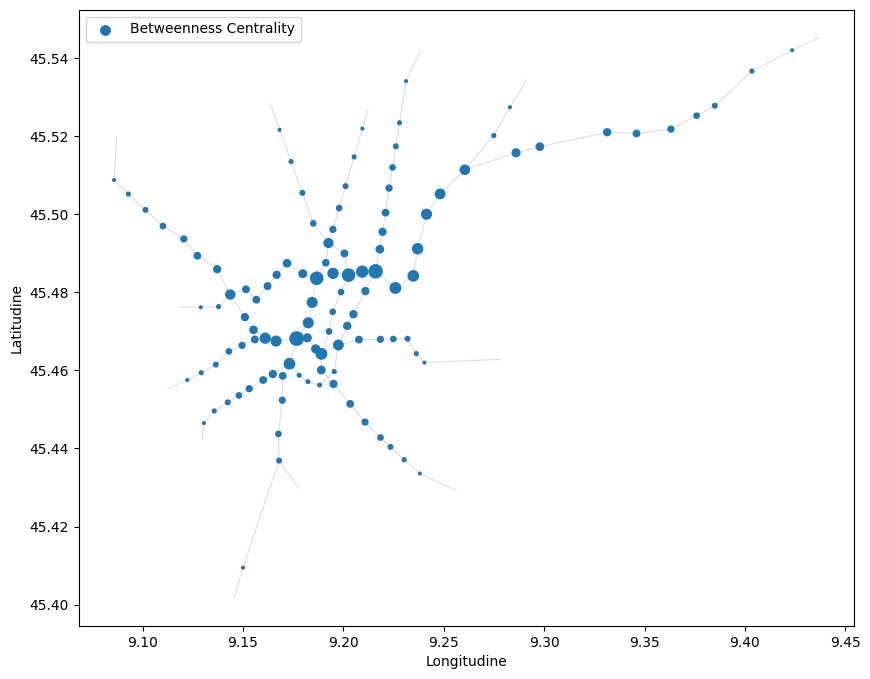

In [146]:
plt.figure(figsize=(10, 8))

edge_color = "#bbbbbb"
for e in G.es:
    v1, v2 = e.tuple
    x = [longitudes[v1], longitudes[v2]]
    y = [latitudes[v1], latitudes[v2]]
    plt.plot(x, y, color=edge_color, linewidth=0.8, alpha=0.5, zorder=1)

plt.scatter(longitudes, latitudes, s=np.array(betweenness_centrality)*0.03, alpha=1, label='Betweenness Centrality')
plt.xlabel('Longitudine')
plt.ylabel('Latitudine')
plt.legend()
plt.show()

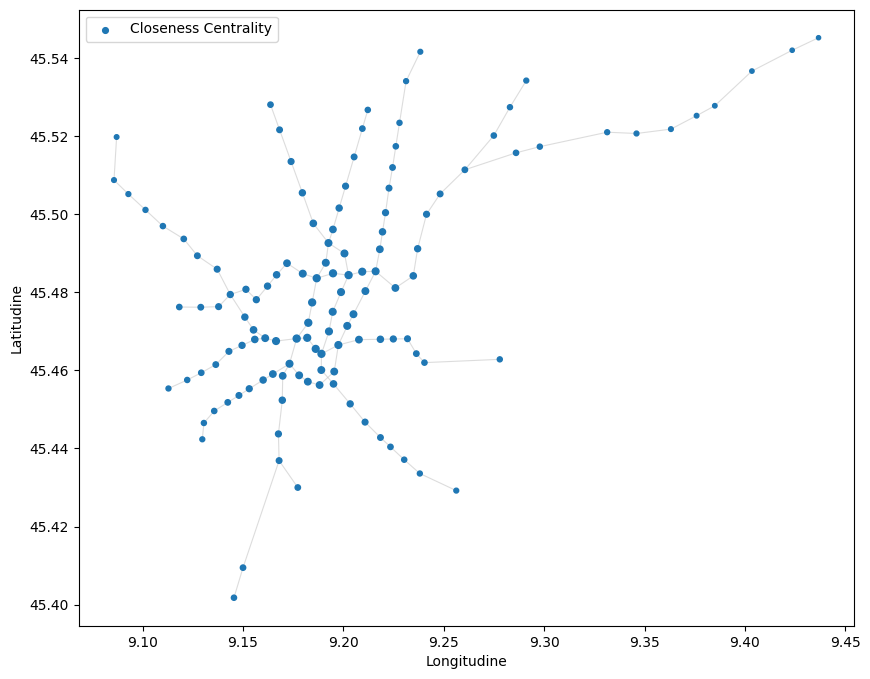

In [147]:
plt.figure(figsize=(10, 8))

edge_color = "#bbbbbb"
for e in G.es:
    v1, v2 = e.tuple
    x = [longitudes[v1], longitudes[v2]]
    y = [latitudes[v1], latitudes[v2]]
    plt.plot(x, y, color=edge_color, linewidth=0.8, alpha=0.5, zorder=1)

plt.scatter(longitudes, latitudes, s=np.array(closeness_centrality)*200, alpha=1, label='Closeness Centrality')
plt.xlabel('Longitudine')
plt.ylabel('Latitudine')
plt.legend()
plt.show()

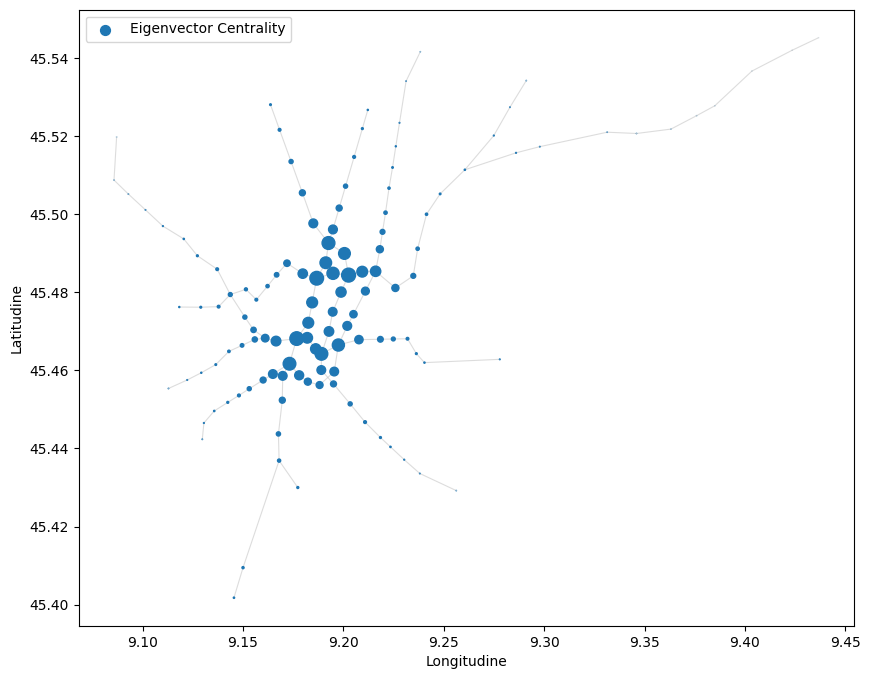

In [148]:
plt.figure(figsize=(10, 8))

edge_color = "#bbbbbb"
for e in G.es:
    v1, v2 = e.tuple
    x = [longitudes[v1], longitudes[v2]]
    y = [latitudes[v1], latitudes[v2]]
    plt.plot(x, y, color=edge_color, linewidth=0.8, alpha=0.5, zorder=1)

plt.scatter(longitudes, latitudes, s=np.array(eigenvector_centrality)*100, alpha=1, label='Eigenvector Centrality')
plt.xlabel('Longitudine')
plt.ylabel('Latitudine')
plt.legend()
plt.show()

# Hubs e assortatività

In [149]:
hubs = G.hub_score()


## Primi 5 hubs

In [150]:
top_n = 5
top_hubs = np.argsort(hubs)[-top_n:][::-1]

print("\nHub scores dei top", top_n, "nodi hub:")
for idx in top_hubs:
    print(f"{G.vs[idx]['stop_name']}: {hubs[idx]:.4f}")


Hub scores dei top 5 nodi hub:
CENTRALE FS: 1.0000
GARIBALDI FS: 0.9679
CADORNA: 0.9571
ZARA: 0.8505
DUOMO: 0.8291


## Assortatività

In [151]:

assortativity_coeff = G.assortativity_degree(directed=False)
print("\nAssortatività del grafo:", assortativity_coeff)


Assortatività del grafo: -0.026489372840539573


---